# Lab 3 - Part 1: Text Visualization & Classical Representations


**Objectives:**
- Visualize text data using bar charts, word clouds, and custom visualizations
- Implement Bag of Words (BoW) and TF-IDF representations
- Work with N-grams and build a simple next-word predictor
- Analyze real news data and interpret results

---

## Instructions

1. Complete all exercises marked with `# YOUR CODE HERE`
2. **Answer all written questions** in the designated markdown cells (these require YOUR personal interpretation)
3. Save your completed notebook
4. **Push to your Git repository and send the link to: yoroba93@gmail.com**
### Important: Personal Interpretation Questions

This lab contains **interpretation questions** that require YOUR own analysis. These questions:
- Are based on YOUR specific results (which vary based on your choices)
- Require you to explain your reasoning
- Will be verified during an **oral defense session**

---

## Setup

In [ ]:
# Install required libraries (uncomment if needed)
# !pip install wordcloud matplotlib numpy pandas scikit-learn fsspec huggingface_hub pillow nltk seaborn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
import string

import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

print("Setup complete!")

Setup complete!


---

## Part A: Loading and Exploring the 20 Newsgroups Dataset (15 min)

We will use the 20 Newsgroups dataset from Hugging Face. This dataset contains news articles from 20 different categories.

In [5]:
# Load the dataset
import pandas as pd
# Use the local CSV included in the lab3 folder to avoid remote downloads
csv_path = "20_newsgroups_train.csv"
df = pd.read_csv(csv_path)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nLabel distribution:")
print(df['label_text'].value_counts())

Dataset shape: (11314, 3)

Columns: ['text', 'label', 'label_text']

Label distribution:
label_text
rec.sport.hockey            600
soc.religion.christian      599
rec.motorcycles             598
rec.sport.baseball          597
sci.crypt                   595
sci.med                     594
rec.autos                   594
sci.space                   593
comp.windows.x              593
comp.os.ms-windows.misc     591
sci.electronics             591
comp.sys.ibm.pc.hardware    590
misc.forsale                585
comp.graphics               584
comp.sys.mac.hardware       578
talk.politics.mideast       564
talk.politics.guns          546
alt.atheism                 480
talk.politics.misc          465
talk.religion.misc          377
Name: count, dtype: int64


In [6]:
# View sample data
print("Sample document:")
print("="*50)
print(f"Label: {df.iloc[0]['label_text']}")
print(f"Text (first 500 chars): {df.iloc[0]['text'][:500]}...")

Sample document:
Label: rec.autos
Text (first 500 chars): I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail....


### Exercise A.1: Select YOUR Categories

**Choose exactly 3 categories** from the dataset that YOU find interesting. This choice is personal and will affect all your subsequent analysis.

**Available categories:**
- alt.atheism, comp.graphics, ...

In [8]:
# TODO: Choose YOUR 3 categories (this affects all your analysis!)
# YOUR CODE HERE
my_categories = ["talk.politics.guns", "talk.politics.mideast", "talk.politics.misc"]  # Replace with your choices

# Filter the dataset
df_filtered = df[df['label_text'].isin(my_categories)].copy()
df_filtered = df_filtered.reset_index(drop=True)

print(f"Selected categories: {my_categories}")
print(f"Filtered dataset size: {len(df_filtered)}")
print(f"\nDistribution:")
print(df_filtered['label_text'].value_counts())

Selected categories: ['talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc']
Filtered dataset size: 1575

Distribution:
label_text
talk.politics.mideast    564
talk.politics.guns       546
talk.politics.misc       465
Name: count, dtype: int64


### Written Question A.1 (Personal Interpretation)

**Why did you choose these 3 specific categories?** Explain your reasoning (at least 3 sentences).

Consider:
- Are they related or completely different?
- What do you expect to find in terms of vocabulary differences?
- Why are they interesting to YOU?

**YOUR ANSWER:**
### yes they are related to plotical 
### I want to know what three articals are corelated to each other and is 
#### talk.political.gun , 
#### talk.political.mideast,
#### talk.political.misc 
#### are there any vocabulary differnces how this vectors to each other

### Iam very curios about the ploitical talks



...

---

## Part B: Text Preprocessing Function

Before visualization, we need to clean our text data.

In [9]:
# Example preprocessing function
# Basic implementation to clean text before tokenization
def preprocess_text(text):
    """Basic text preprocessing."""
    if not isinstance(text, str):
        return ''
    # Lowercase
    text = text.lower()
    # Remove emails
    text = re.sub(r'\S+@\S+', ' ', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    # Remove numbers
    text = re.sub(r'\d+', ' ', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Test
sample = "Hello! Check this: http://example.com. Email me at test@email.com. Price: $100."
print(f"Original: {sample}")
print(f"Cleaned:  {preprocess_text(sample)}")

Original: Hello! Check this: http://example.com. Email me at test@email.com. Price: $100.
Cleaned:  hello check this email me at price


### Exercise B.1: Improve the Preprocessing Function

The function above is basic. **Improve it** by adding:
1. Stop word removal
2. Lemmatization
3. Minimum word length filter (remove words with < 3 characters)

In [21]:
# Improved preprocessing: stop words removal, lemmatization, min length filter
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text_advanced(text):
    """
    Advanced text preprocessing with stop words removal and lemmatization.
    """
    if not isinstance(text, str):
        return ''
    # Step 1: Basic cleaning
    text = text.lower()
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()

    # Step 2: Tokenize using a simple regex tokenizer (avoids NLTK resource issues)
    tokens = re.findall(r'\b\w+\b', text)

    # Step 3: Remove stop words and short tokens
    tokens = [t for t in tokens if t not in stop_words and len(t) >= 3]

    # Step 4: Lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    # Step 5: Join back to string
    return ' '.join(tokens)

# Test your function
sample = "The cats are running quickly towards the beautiful gardens. Email: test@mail.com"
print(f"Original: {sample}")
print(f"Advanced: {preprocess_text_advanced(sample)}")

Original: The cats are running quickly towards the beautiful gardens. Email: test@mail.com
Advanced: cat running quickly towards beautiful garden email


In [22]:
# Apply preprocessing to your filtered dataset
df_filtered['text_clean'] = df_filtered['text'].apply(preprocess_text_advanced)

# Show sample
print("Sample preprocessed document:")
print(df_filtered.iloc[0]['text_clean'][:300])

Sample preprocessed document:
course term must rigidly defined bill doubt us term using quote allegedly back read article presenting first argument weapon mass destruction commonly understood switching topic first point evidently show weapon allowed later analysis given understanding consider another class


---

## Part C: Text Visualization

### C.1 Bar Chart: Top Words per Category

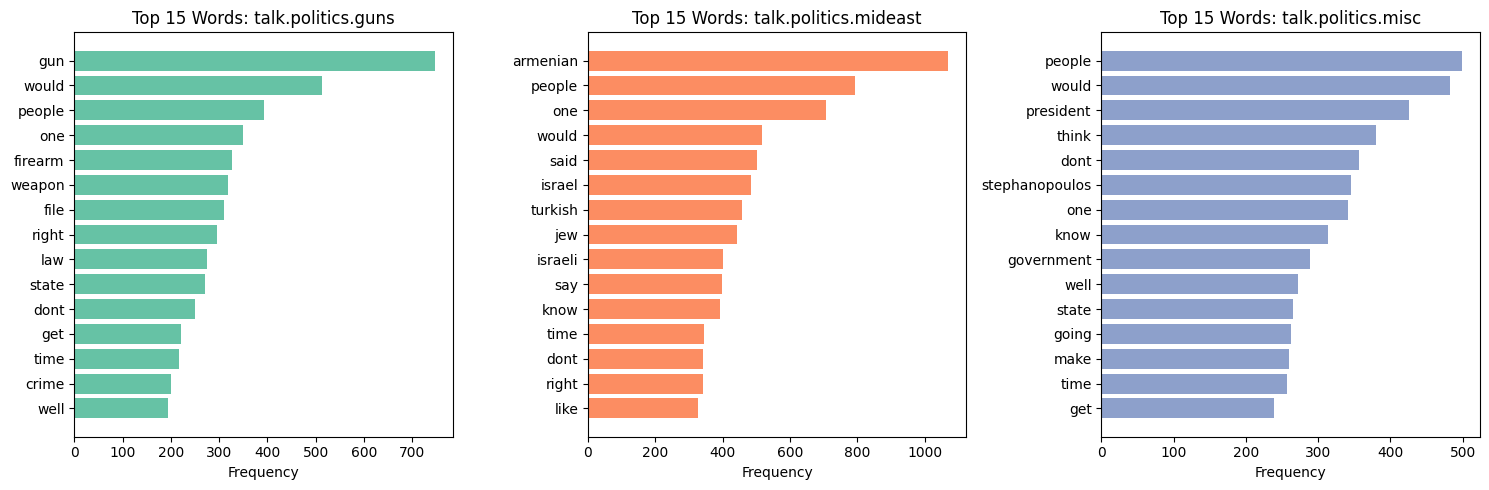

In [23]:
def get_top_words(texts, n=15):
    """Get the n most common words from a list of texts."""
    all_words = ' '.join(texts).split()
    word_counts = Counter(all_words)
    return word_counts.most_common(n)

# Get top words for each category
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, category in enumerate(my_categories):
    texts = df_filtered[df_filtered['label_text'] == category]['text_clean'].tolist()
    top_words = get_top_words(texts, 15)
    
    words, counts = zip(*top_words)
    axes[idx].barh(words, counts, color=plt.cm.Set2(idx))
    axes[idx].set_title(f'Top 15 Words: {category}')
    axes[idx].invert_yaxis()
    axes[idx].set_xlabel('Frequency')

plt.tight_layout()
plt.savefig('top_words_by_category.png', dpi=150, bbox_inches='tight')
plt.show()

In [35]:
# Compute top words per category and select 14 unique words
top_words_per_category = {}
for category in my_categories:
    texts = df_filtered[df_filtered['label_text'] == category]['text_clean'].dropna().tolist()
    top = get_top_words(texts, 15)
    top_words_per_category[category] = [w for w, _ in top]

from collections import Counter
word_cat_count = Counter()
for cat, words in top_words_per_category.items():
    for w in set(words):
        word_cat_count[w] += 1

# Words that appear in exactly one category (unique to one category)
unique_words = [w for w, c in word_cat_count.items() if c == 1]

# Global frequency to help fill if fewer than 14 unique words
global_counts = Counter(' '.join(df_filtered['text_clean'].fillna('')).split())
unique_sorted = sorted(unique_words, key=lambda w: global_counts.get(w, 0), reverse=True)
selected = unique_sorted[:14]
if len(selected) < 14:
    all_top_union = list({w for words in top_words_per_category.values() for w in words})
    for w in sorted(all_top_union, key=lambda w: global_counts.get(w, 0), reverse=True):
        if w in selected:
            continue
        selected.append(w)
        if len(selected) >= 14:
            break

unique_14_set = set(selected)
print(f"Selected {len(unique_14_set)} unique words (up to 14): {unique_14_set}")

Selected 14 unique words (up to 14): {'like', 'law', 'said', 'president', 'turkish', 'government', 'think', 'armenian', 'israel', 'say', 'jew', 'gun', 'going', 'make'}


In [39]:
# the words share accross the three catogeries
shared_words=[]
for _catoger in my_categories:
    _texts = df_filtered[df_filtered['label_text'] == _catoger]['text_clean'].tolist()
print(f"shared catogeris are {shared_words}")

shared catogeris are []


### Written Question C.1 (Personal Interpretation)

Look at your bar charts above and answer:

1. **What words are UNIQUE to each category?** (List at least 2 per category)
2. **What words are SHARED across categories?** Why do you think they appear in multiple categories?
3. **Based ONLY on the top words, could you guess the topic of each category?** Explain.

**YOUR ANSWER:**

*Category 1 (talk.political.guns):*
- Unique words:
 talk.politics.guns ------> 14 words:
 {'weaver', 'hci', 'rkba', 'people', 'antigun', 'firearm', 'semiautomatic', 'one', 'bd', 'would', 'weapon', 'gun', 'nra', 'atf'}

- 

*Category 2 (talk.politics.mideast):*
- Unique words: ---> 14 words: 
{'azerbaijani', 'argic', 'arab', 'baku', 'mamma', 'serdar', 'henrik', 'xsoviet', 'ottoman', 'armenian', 'palestinian', 'sumgait', 'azeri', 'azerbaijan'}
- 

*Category 3 (talk.politics.misc):*
- Unique words: ----> 14 words: 
{'people', 'vat', 'stimulus', 'rockefeller', 'dont', 'bolshevik', 'one', 'dole', 'stephanopoulos', 'think', 'dee', 'would', 'president', 'know'}
- 

*Shared words and explanation:*
...

*Topic guessing analysis:*
...

### C.2 Word Clouds

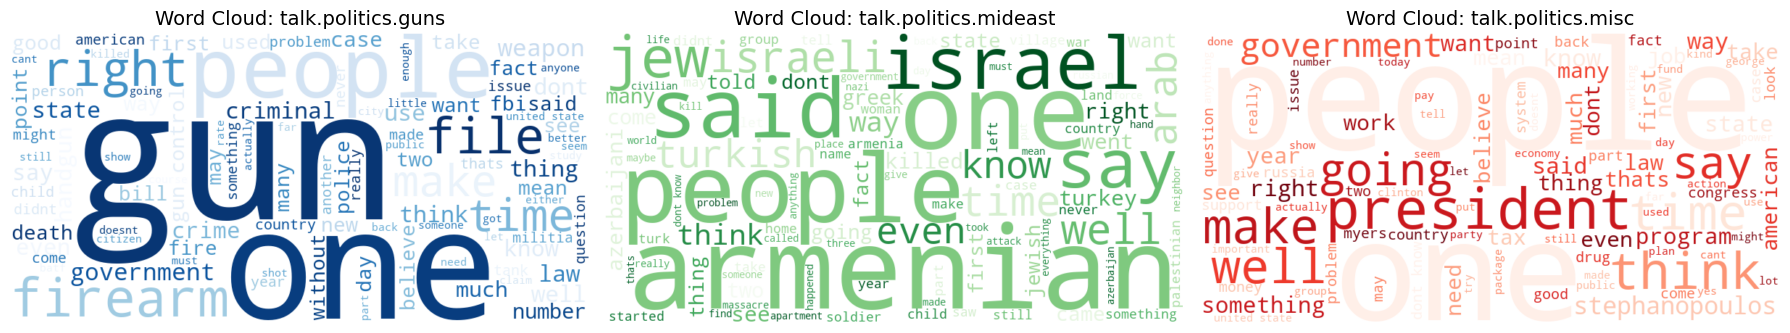

In [36]:
# Simple word cloud for each category
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

colors = ['Blues', 'Greens', 'Reds']

for idx, category in enumerate(my_categories):
    texts = df_filtered[df_filtered['label_text'] == category]['text_clean'].tolist()
    text_combined = ' '.join(texts)
    
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        colormap=colors[idx],
        max_words=100,
        min_font_size=10
    ).generate(text_combined)
    
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Word Cloud: {category}', fontsize=14)
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('wordclouds_by_category.png', dpi=150, bbox_inches='tight')
plt.show()

### Exercise C.2: Custom Shaped Word Cloud

Create a word cloud using a **custom mask image**. 

**Instructions:**
1. Find or create a simple black & white silhouette image (PNG format)
2. Save it in your working directory
3. Use it as a mask for your word cloud

**Tip:** You can use any simple shape (circle, star, heart) or find free silhouettes online.

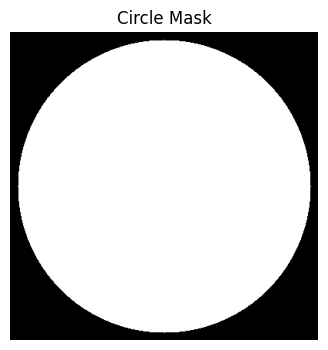

In [40]:
# Example: Creating a circular mask programmatically
# (You can replace this with your own image)

from PIL import Image

# Create a circular mask
def create_circle_mask(size=400):
    x = np.arange(0, size)
    y = np.arange(0, size)
    cx, cy = size // 2, size // 2
    r = size // 2 - 10
    mask = np.zeros((size, size), dtype=np.uint8)
    for i in x:
        for j in y:
            if (i - cx)**2 + (j - cy)**2 <= r**2:
                mask[j, i] = 255
    return mask

circle_mask = create_circle_mask(400)

# Show the mask
plt.figure(figsize=(4, 4))
plt.imshow(circle_mask, cmap='gray')
plt.title('Circle Mask')
plt.axis('off')
plt.show()

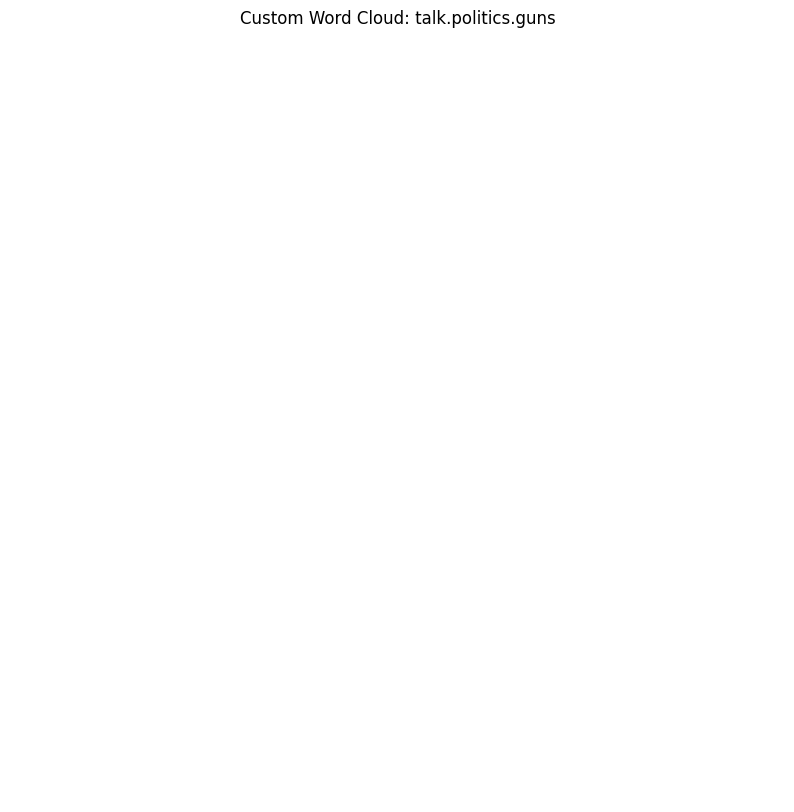

In [42]:
# TODO: Create a custom word cloud with a mask
# Choose ONE of your categories for this visualization

# YOUR CODE HERE
selected_category = my_categories[0]  # Choose one of your categories

# Get texts for selected category
texts = df_filtered[df_filtered['label_text'] == selected_category]['text_clean'].tolist()
text_combined = ' '.join(texts)

# Create word cloud with mask
# Hint: Use the mask parameter in WordCloud()
# wordcloud = WordCloud(..., mask=your_mask, ...).generate(text_combined)

wordcloud_masked = None  # YOUR CODE HERE

# Display
plt.figure(figsize=(10, 10))
# YOUR CODE HERE - display the wordcloud
plt.title(f'Custom Word Cloud: {selected_category}')
plt.axis('off')
plt.savefig('custom_wordcloud.png', dpi=150, bbox_inches='tight')
plt.show()

---

## Part D: Bag of Words (BoW) Representation 

In [43]:
# Example: Simple Bag of Words
sample_docs = [
    "I love machine learning",
    "Machine learning is great",
    "I love deep learning too"
]

# Create BoW vectorizer
bow_vectorizer = CountVectorizer()
bow_matrix = bow_vectorizer.fit_transform(sample_docs)

# Show vocabulary
print("Vocabulary:", bow_vectorizer.get_feature_names_out())
print("\nBoW Matrix (dense):")
print(bow_matrix.toarray())

# As DataFrame
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=bow_vectorizer.get_feature_names_out())
print("\nAs DataFrame:")
bow_df

Vocabulary: ['deep' 'great' 'is' 'learning' 'love' 'machine' 'too']

BoW Matrix (dense):
[[0 0 0 1 1 1 0]
 [0 1 1 1 0 1 0]
 [1 0 0 1 1 0 1]]

As DataFrame:


,deep,great,is,learning,love,machine,too
0,0,0,0,1,1,1,0
1,0,1,1,1,0,1,0
2,1,0,0,1,1,0,1


### Exercise D.1: Create BoW for Your Dataset

In [44]:
# TODO: Create a Bag of Words representation for your filtered dataset
# Use parameters: max_features=1000, min_df=5, max_df=0.95

# YOUR CODE HERE
bow_vectorizer_full = CountVectorizer(
    # Add your parameters
)

# Fit and transform on your cleaned texts
bow_matrix_full = None  # YOUR CODE HERE

print(f"BoW Matrix shape: {bow_matrix_full.shape}")
print(f"Vocabulary size: {len(bow_vectorizer_full.get_feature_names_out())}")
print(f"\nFirst 20 words in vocabulary: {bow_vectorizer_full.get_feature_names_out()[:20]}")

AttributeError: 'NoneType' object has no attribute 'shape'

### Exercise D.2: Document Similarity with BoW

In [45]:
from sklearn.metrics.pairwise import cosine_similarity

# TODO: Compute cosine similarity between documents
# Then find the 2 most similar documents and the 2 most different documents

# Compute similarity matrix
similarity_matrix = None  # YOUR CODE HERE

print(f"Similarity matrix shape: {similarity_matrix.shape}")

AttributeError: 'NoneType' object has no attribute 'shape'

In [46]:
# TODO: Find the 2 most similar documents (excluding self-similarity)
# Hint: Set diagonal to 0 or -1, then find argmax

# YOUR CODE HERE

# Find indices of most similar pair
most_similar_idx = None  # (idx1, idx2)
most_similar_score = None

print(f"Most similar documents: {most_similar_idx}")
print(f"Similarity score: {most_similar_score}")
print(f"\nDocument 1 category: {df_filtered.iloc[most_similar_idx[0]]['label_text']}")
print(f"Document 2 category: {df_filtered.iloc[most_similar_idx[1]]['label_text']}")

Most similar documents: None
Similarity score: None


TypeError: 'NoneType' object is not subscriptable

### Written Question D.1 (Personal Interpretation)

Look at the 2 most similar documents you found:

1. **Are they from the same category or different categories?**
2. **Read the original texts (first 200 characters). What makes them similar?**
3. **Is the BoW similarity measure meaningful here? Why or why not?**

In [ ]:
# Show the similar documents for your analysis
print("Document 1 (first 300 chars):")
print(df_filtered.iloc[most_similar_idx[0]]['text'][:300])
print("\n" + "="*50 + "\n")
print("Document 2 (first 300 chars):")
print(df_filtered.iloc[most_similar_idx[1]]['text'][:300])

**YOUR ANSWER:**

*[Write your analysis here - answer all 3 questions]*

1. Same or different category: ...

2. What makes them similar: ...

3. Is BoW meaningful here: ...

---

## Part E: TF-IDF Representation

In [ ]:
# Example: TF-IDF
sample_docs = [
    "I love machine learning",
    "Machine learning is great",
    "I love deep learning too"
]

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(sample_docs)

print("TF-IDF Matrix:")
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(), 
    columns=tfidf_vectorizer.get_feature_names_out()
)
tfidf_df.round(3)

In [ ]:
# Compare BoW vs TF-IDF for the word "learning"
print("Word 'learning' scores:")
print(f"  BoW:    {bow_df['learning'].tolist()}")
print(f"  TF-IDF: {tfidf_df['learning'].round(3).tolist()}")
print("\nNotice: TF-IDF gives LOWER scores to common words!")

### Exercise E.1: TF-IDF Analysis

In [ ]:
# TODO: Create TF-IDF representation for your dataset
# Use same parameters: max_features=1000, min_df=5, max_df=0.95

tfidf_vectorizer_full = TfidfVectorizer(
    # YOUR PARAMETERS HERE
)

tfidf_matrix_full = None  # YOUR CODE HERE

print(f"TF-IDF Matrix shape: {tfidf_matrix_full.shape}")

In [ ]:
# TODO: Find the top 10 most important words (highest TF-IDF) for each of your 3 categories

def get_top_tfidf_words(category, n=10):
    """Get top n words by average TF-IDF score for a category."""
    # YOUR CODE HERE
    # 1. Get indices of documents in this category
    # 2. Get their TF-IDF vectors
    # 3. Compute mean TF-IDF for each word across these documents
    # 4. Return top n words
    pass

# Display top words for each category
for category in my_categories:
    top_words = get_top_tfidf_words(category, 10)
    print(f"\nTop TF-IDF words for '{category}':")
    print(top_words)

### Written Question E.1 (Personal Interpretation)

Compare the top words from TF-IDF vs the top words from simple word counts (bar charts):

1. **What words appear in TF-IDF top 10 but NOT in the word count top 15?**
2. **What words appear in word count top 15 but NOT in TF-IDF top 10?**
3. **Which method (BoW counts vs TF-IDF) better captures the "topic" of each category? Explain why.**

**YOUR ANSWER:**

*[Write your comparative analysis here]*

1. Words in TF-IDF but not counts: ...

2. Words in counts but not TF-IDF: ...

3. Which method is better and why: ...

---

## Part F: N-grams and Next Word Prediction

In [ ]:
# Example: Extracting N-grams
from nltk import ngrams

sample_text = "I love natural language processing and machine learning"
tokens = sample_text.split()

# Bigrams (n=2)
bigrams = list(ngrams(tokens, 2))
print("Bigrams:", bigrams)

# Trigrams (n=3)
trigrams = list(ngrams(tokens, 3))
print("Trigrams:", trigrams)

In [ ]:
# Using CountVectorizer for n-grams
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2))  # Only bigrams
trigram_vectorizer = CountVectorizer(ngram_range=(3, 3))  # Only trigrams
mixed_vectorizer = CountVectorizer(ngram_range=(1, 3))    # Unigrams, bigrams, and trigrams

sample_docs = ["I love machine learning", "Machine learning is great"]

bigrams_matrix = bigram_vectorizer.fit_transform(sample_docs)
print("Bigram features:", bigram_vectorizer.get_feature_names_out())

### Exercise F.1: Analyze Bigrams in Your Dataset

In [ ]:
# TODO: Find the top 15 most common bigrams for each of your categories

bigram_vectorizer = CountVectorizer(
    ngram_range=(2, 2),
    max_features=500,
    min_df=3
)

# YOUR CODE HERE
# For each category:
# 1. Get the texts
# 2. Fit the bigram vectorizer
# 3. Find most common bigrams

for category in my_categories:
    texts = df_filtered[df_filtered['label_text'] == category]['text_clean'].tolist()
    
    # YOUR CODE HERE
    top_bigrams = []  # Get top 15 bigrams
    
    print(f"\nTop bigrams for '{category}':")
    for bigram, count in top_bigrams[:15]:
        print(f"  {bigram}: {count}")

### Exercise F.2: Simple Next Word Predictor

Build a simple next-word predictor using bigram probabilities.

In [ ]:
# TODO: Build a bigram-based next word predictor

class SimpleNextWordPredictor:
    def __init__(self):
        self.bigram_counts = {}  # {word1: {word2: count, word3: count, ...}}
        self.unigram_counts = {}  # {word: count}
    
    def train(self, texts):
        """
        Train the model on a list of texts.
        
        Args:
            texts (list): List of preprocessed text strings
        """
        # YOUR CODE HERE
        # 1. For each text, tokenize into words
        # 2. Count unigrams
        # 3. Count bigrams (word pairs)
        pass
    
    def predict_next(self, word, top_n=5):
        """
        Predict the most likely next words given a word.
        
        Args:
            word (str): The input word
            top_n (int): Number of predictions to return
            
        Returns:
            list: List of (next_word, probability) tuples
        """
        # YOUR CODE HERE
        # 1. Look up the word in bigram_counts
        # 2. Calculate probabilities: P(word2|word1) = count(word1, word2) / count(word1)
        # 3. Return top_n predictions sorted by probability
        return []

# Train on your dataset
predictor = SimpleNextWordPredictor()
predictor.train(df_filtered['text_clean'].tolist())

In [ ]:
# Test your predictor with words relevant to your categories
# TODO: Choose 5 test words that are relevant to YOUR chosen categories

test_words = ["___", "___", "___", "___", "___"]  # Replace with your words

print("Next Word Predictions:")
print("=" * 40)

for word in test_words:
    predictions = predictor.predict_next(word.lower(), top_n=5)
    print(f"\n'{word}' ->")
    for next_word, prob in predictions:
        print(f"  {next_word}: {prob:.3f}")

### Written Question F.1 (Personal Interpretation)

Analyze your next-word predictor results:

1. **Were the predictions sensible?** Give 2 examples of good predictions and 2 examples of bad predictions.
2. **What are the limitations of this simple bigram model?**
3. **How could you improve this predictor?** (List at least 3 ideas)

**YOUR ANSWER:**

1. Good predictions:
   - ...
   - ...
   
   Bad predictions:
   - ...
   - ...

2. Limitations: ...

3. Improvement ideas:
   - ...
   - ...
   - ...

---

## Part G: Document Correlation Matrix

In [ ]:
# TODO: Create a correlation/similarity heatmap between documents
# Sample 10 documents from each of your 3 categories (30 total)

import seaborn as sns

# Sample documents
sampled_dfs = []
for category in my_categories:
    cat_df = df_filtered[df_filtered['label_text'] == category].sample(n=10, random_state=42)
    sampled_dfs.append(cat_df)

df_sampled = pd.concat(sampled_dfs).reset_index(drop=True)

# Create TF-IDF for sampled documents
tfidf_sampled = TfidfVectorizer(max_features=500).fit_transform(df_sampled['text_clean'])

# Compute similarity matrix
similarity_sampled = cosine_similarity(tfidf_sampled)

# Create labels for heatmap
labels = [f"{cat[:6]}_{i}" for cat, i in zip(df_sampled['label_text'], range(len(df_sampled)))]

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    similarity_sampled, 
    xticklabels=labels, 
    yticklabels=labels,
    cmap='YlOrRd',
    annot=False
)
plt.title('Document Similarity Matrix (TF-IDF Cosine Similarity)')
plt.tight_layout()
plt.savefig('document_similarity_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

### Written Question G.1 (Personal Interpretation)

Analyze the similarity heatmap:

1. **Do documents from the same category cluster together?** (i.e., do you see bright squares along the diagonal for each category group?)
2. **Which pair of categories is MOST similar to each other?** Which is LEAST similar?
3. **Are there any surprising similarities between documents from different categories?** If yes, what might explain this?

**YOUR ANSWER:**

1. Clustering observation: ...

2. Most/Least similar category pairs: ...

3. Surprising similarities: ...

---

## Summary - Part 1

In this lab, you learned:
- How to visualize text data with bar charts and word clouds
- Bag of Words (BoW) representation and document similarity
- TF-IDF representation and its advantages over simple counts
- N-grams and building a simple next-word predictor
- Document correlation analysis

---

## Submission Checklist - Part 1

- [ ] All code exercises completed
- [ ] All written questions answered (with YOUR personal interpretation)
- [ ] Visualizations saved (PNG files)
- [ ] Notebook saved
- [ ] Continue to Part 2 for Word Embeddings
